In [ ]:
!pip3 install -U datatops==0.2.2 gensim==4.3.1 matplotlib==3.7.1 matplotlib-inline==0.1.3 numpy==1.24.2 requests==2.28.2 requests-oauthlib==1.3.0 scikit-learn==1.2.2 vibecheck==0.0.3 pytorch_lightning torch tqdm ipywidgets datasets transformers typing_extensions

# Tokenizers: Preface

* **Authors**: Jordan Matelsky
* **Reviewers**: Lyle Ungar, Konrad Kording

**A GPU is recommended for this notebook.**

> * This notebook will use a new feedback mechanism to get vibe-checks throughout the notebook; please do feel encouraged to click the feedback buttons to submit anonymous feedback! This will not count toward your grade.
> * In general, Jupyter notebooks should follow good code-style practices, and all the imports should go at the top. But because much of this code might be useful to you in the future, we will leave cells with imports in them throughout the notebook so that it is easy to copy and paste to reuse this code. For more information on notebook best practices, see [here](https://gist.github.com/j6k4m8/864fb5a8a2257237169a48b6bd6a307e).


## Section 1: Overview of NLP

Natural Language Processing (NLP) techniques process and analyze large amounts of natural language data. 
NLP applications include:

1.   Sentiment Analysis: Understanding the views of people/customers towards a specific product or service. 
2.   Virtual Assistants: Alexa, Siri and Google Assistant, etc.
3.   Machine Translation: Translating speech or text from one language to another.  
4.   Information retrieval and search engines
5.   Question Answering
6.   Summarization
7.   Identifying Fake News and spam: Ironically, NLP can also be used to generate fake news.

NLP is also increasingly being used in recruitment decisions, litigation tasks, etc.


In [ ]:
# @title Feedback setup (run this cell)

# Feedback with Datatops
from vibecheck import DatatopsContentReviewContainer
from datatops import Datatops

feedback_dtid = "62a48t3w"
feedback_name = "cis522_feedback"
quiz_dtid = "lxx8szk1"
quiz_name = "cis522_quiz"
notebook_name = "W9D2_Tokenizers"
dt_url = "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab/"

# Instantiate the Datatops client
dt = Datatops(dt_url)
quizdt = dt.get_project(quiz_name, user_key=quiz_dtid)


In [ ]:
my_pennkey = "" #@param {type:"string"}
my_pod = "" #@param {type:"string"}
my_email = "" #@param {type:"string"}

Video available at https://youtube.com/watch?v=TZv5NmAjUyA


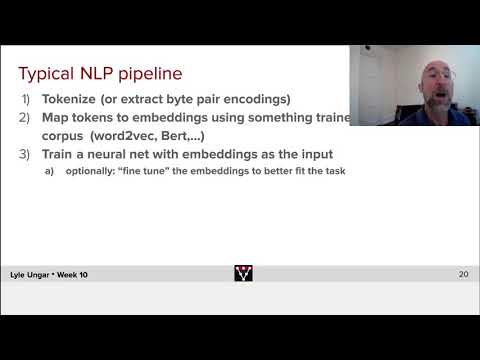

In [1]:
#@title Video : Language Processing
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="TZv5NmAjUyA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

# Tokenizers

In the previous notebook, we discussed a few ways to represent words as vectors: We generated one-hot encodings of words in a vocabulary, and saw that it lacked the ability to cluster similar words. We then generated context-free embeddings, and saw that they clustered words together but could not distinguish different meanings of the same word (for example, homonyms or alternate uses). Today, we will complete our triptych of embedding techniques, and continue our march toward large language models and transformers by discussing one of the critical developments of the modern NLP stack: **Tokenization.**

### Learning Goals

* Write a tokenizer from scratch, taking advantage of context. Play with a few pre-trained tokenizers from industry.
* Discuss RNNs and LSTMs
* Advanced discussions in neural memory
* Deep-dive discussion of vanishing gradients with long sequences




## Generating a dataset

We wrote our own embedders as an academic exercise; as we continue to move closer to "production-grade" NLP, we'll start to use industry standards such as the [HuggingFace](https://huggingface.co/) library. 

We'll start by generating a training dataset (like we used Moby Dick in the previous day's notebooks). `hf` has a convenient `datasets` module that allows us to download a variety of datasets, including the [Wikipedia text corpus](https://huggingface.co/datasets/wiki_text). We'll use this to generate a dataset of text from Wikipedia:

In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train")

In [ ]:
print(dataset[41492])

In [ ]:
def generate_n_examples(dataset, n=512):
    """
    Produce a generator that yields n examples at a time from the dataset.
    """
    for i in range(0, len(dataset), n):
        yield dataset[i:i + n]['text']

Now we are going to create the actual `Tokenizer`, adhering to the [`hf.Tokenizer` protocol](https://huggingface.co/docs/transformers/main_classes/tokenizer). (Much like we did last time by adhering to a standard protocol, this enables us to swap in our tokenizer for any tokenizer in the huggingface ecosystem, or to apply our own tokenizer to any model in the huggingface ecosystem.) 

Let's sketch out the steps of writing a Tokenizer. We need to solve two problems:

* Given a string, split it into a list of tokens.
* If you don't recognize a word, still figure out a way to tokenize it!

This may feel like we're reinventing our one-hot encoder from the previous notebook, but with a richer vocabulary. Why is it that the OHE, which output a vector of length `|V|`, where `|V|` is the size of our vocabulary, is not sufficient, but a tokenizer that outputs a list of indices into a vocabulary of size `|V|` is sufficient? The answer is that while our encoder was responsible for embedding words into a high-dimensional space, our tokenizer is NOT; the "win" of a tokenizer is that it breaks up a string into in-vocab elements. For certain workflows, the very next step might be adding an embedder onto the end of the tokenizer. (As we'll soon see, this is exactly the strategy employed by modern Transformer models.) 

Tokens will almost always be different from words; for example, we might want to split "don't" into "do" and "n't", or we might want to split "don't" into "do" and "not". Or we might even want to split "don't" into "d", "o", "n", and "t". We can choose any strategy we want here; **unlike Word2Vec, our tokenizer will NOT be limited to outputting one vector per English word.** Here, we'll use an off-the-shelf subword splitter, which we discuss below.

In [ ]:
# Try playing with these hyperparameters!
VOCAB_SIZE = 12_000 

In [ ]:
from tokenizers import Tokenizer, Regex, models, normalizers, pre_tokenizers, trainers, processors

# Create a tokenizer object that uses the "WordPiece" model. The WorkPiece model
# is a subword tokenizer that uses a vocabulary of common words and word pieces
# to tokenize text. The "unk_token" parameter specifies the token to use for
# unknown tokens, i.e. tokens that are not in the vocabulary. (Remember that the
# vocabulary will be built from our dataset, so it will include subchunks of 
# English words.)
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

### Tokenizer Features

Now let's start dressing up our tokenizer with some useful features. First, let's clean up the text. This process is formally called "normalization", and it is a critical step in any NLP pipeline. We'll start by removing punctuation, and then we'll convert all the text to lowercase. We'll also remove diacritics (accents) from the text:

In [ ]:
# Think of a Normalizer Sequence the same way you would think of a PyTorch
# Sequential model. It is a sequence of normalizers that are applied to the
# text before tokenization, in the order that they are added to the sequence.

tokenizer.normalizer = normalizers.Sequence([
    normalizers.Replace(Regex(r"[\s]"), " "), # Convert all whitespace to single space
    normalizers.Lowercase(), # Convert all text to lowercase
    normalizers.NFD(), # Decompose all characters into their base characters
    normalizers.StripAccents(), # Remove all accents
])

Next we'll add a pre-tokenizer. The pre-tokenizer is applied to the text after we normalize it, but before it's tokenized. The pre-tokenizer is useful for splitting text into chunks that are easier to tokenize. For example, we can split text into chunks that are separated by punctuation or whitespace:

In [ ]:
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    pre_tokenizers.WhitespaceSplit(), # Split on whitespace
    pre_tokenizers.Digits(individual_digits=True), # Split digits into individual tokens
    pre_tokenizers.Punctuation(), # Split punctuation into individual tokens
])

Finally we'll train the tokenizer with our dataset. There are a few different algorithms for training tokenizers. Here are two common ones:

* BPE Algorithm: Start with a vocabulary of each character in the dataset. Examine all pairs from the vocabulary and merge the pair with the highest frequency in the dataset. Repeat until the vocabulary size is reached. (So "ee" is more likely to get merged than "zf" in the english corpus)
* Top-Down WordPiece Algorithm: Generate all substrings of each word from the dataset and count occurrences in the training data. Keep any string that occurs more than a threshold number of times. Repeat this process until the vocabulary size is reached. (For a more thorough explanation of this process, see [the TensorFlow Guide](https://www.tensorflow.org/text/guide/subwords_tokenizer#optional_the_algorithm).)

We'll use WordPiece:

In [ ]:
tokenizer_trainer = trainers.WordPieceTrainer(
    vocab_size=VOCAB_SIZE,
    # We have to specify the special tokens that we want to use. These will be
    # added to the vocabulary no matter what the vocab-building algorithm does.
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
    show_progress=True,
)


Those special tokens are important because it tells the WordPiece training process how to treat phrases, masks, and unknown tokens. (Note that we can also add our own special tokens, such as `[CITE]` to indicate when a citation is about to be used, if we wanted to train a model to predict the presence of citations in a text.)

In [ ]:
tokenizer.train_from_iterator(generate_n_examples(dataset), trainer=tokenizer_trainer)

In [ ]:
# In "real life", we'd probably want to save the tokenizer to disk so that we
# can use it later. We can do this with the "save" method:
# tokenizer.save("tokenizer.json")

# Let's try it out!
print("Hello, world!")
print(
    *zip(
        tokenizer.encode("Hello, world!").tokens,
        tokenizer.encode("Hello, world!").ids,
    )
)


# Can we also tokenize made-up words?
print(tokenizer.encode("These toastersocks are so groommpy!").tokens)


(The `##` means that the token is a continuation of the previous chunk.)

Try playing around with the hyperparameters and the tokenizing algorithms to see how they affect the tokenizer's output. There can be some very major differences!

In summary, we created a tokenizer pipeline that:

* Normalizes the text (cleans up punctuation and diacritics)
* Splits the text into chunks (using whitespace and punctuation)
* Trains the tokenizer on the dataset (using the WordPiece algorithm)

In common use, this would be the first step of any modern NLP pipeline. The next step would be to add an embedder to the end of the tokenizer, which we'll do shortly, so that we can feed in a high-dimensional space to our model. But unlike Word2Vec, we can now separate the tokenization step from the embedding step, which means our encoding/embedding process can be task-specific, custom to our downstream neural net architecture, instead of general-purpose.


## Quiz!

**We established that the tokenizer is a better move than the OHE because it can handle out-of-vocabulary words. But what if we just made a one-hot encoding where the vocabulary is all possible two-character combinations? Would there still be an advantage to the tokenizer?** (Hint: Re-read the section on the BPE and WordPiece algorithms, and how the tokens are selected.)

In [ ]:
tokenizer_vs_combinatorial_ohe = "" #@param {type:"string"}

**Let's think about a language like Chinese, where words are each composed of a relatively fewer number of characters compared to English (`hungry` is six unicode characters, but `饿` is one unicode character), but there are many more unique Chinese characters than there are letters in the English alphabet. In a one or two sentence high-level sketch, what properties would be desireable for a Chinese tokenizer to have?**

In [ ]:
useful_chinese_tokenizer_properties = "" #@param {type:"string"}

In [ ]:
#@title .
DatatopsContentReviewContainer(
    "",
    "W9D2_Tokenizers",
    {
        "url": dt_url,
        "name": feedback_name,
        "user_key": feedback_dtid,
    }
).render()

## Natural Language Processing with Neural Networks

This week, we've gone deep on the theory of how to cram natural language — a squishy, fickle thing — into a neural network, a machine that expects numerical and quantifiable inputs. In the next section, we'll start to see how we can use these resources to build powerful natural language processing models.

First, let's motivate things with an example. Autocomplete is a common feature in nearly every text-editing experience these days; the task is quite simple. Given a string of text, we want the machine to predict the next word.

Let's rewind our brains to 2010; how might we have solved this task without a neural network? One obvious answer is a Markov chain. A Markov process is a state machine that transitions from one state to another based on the current state and a probability distribution. For example, consider the following diagram:

[![](https://mermaid.ink/img/pako:eNp9j7EOgkAMhl_l0tEAQROXG5z0CRw5h4YregnHmdIzMYR3twiudur_5WvaTtAmT2BhFBQ6B7wzxvJ1cIPRanY3U5YnIw-yZl_VK9X0pTGx4ro6rniJ_2xiDsTbABSgIGLwuntaTAdqRnJgtfXUYe7FgRtmVfPT63UXHyQx2A77kQrALOn6Hlqwwpl-0vbCZs0f2qFFcA?type=png)](https://mermaid.live/edit#pako:eNp9j7EOgkAMhl_l0tEAQROXG5z0CRw5h4YregnHmdIzMYR3twiudur_5WvaTtAmT2BhFBQ6B7wzxvJ1cIPRanY3U5YnIw-yZl_VK9X0pTGx4ro6rniJ_2xiDsTbABSgIGLwuntaTAdqRnJgtfXUYe7FgRtmVfPT63UXHyQx2A77kQrALOn6Hlqwwpl-0vbCZs0f2qFFcA)

The sentence "the more the merrier" has been encoded here as a Markov process. If you are at state "the", you have a 50% chance of transitioning to "more", and a 50% chance of transitioning to "merrier". If you are at state "more", you have a 100% chance of transitioning to "the". 

It is very easy to construct a Markov model; simply walk along your input corpus and count the number of times each word follows another word. Then, normalize the counts to get a probability distribution.  And it's very easy to reconstruct a sequence from a Markov model; just walk along the graph, and pick the next state change based on the probability distribution of your current state.

One issue with this approach is that it doesn't take into account the context of the word. For example, sitting at the node "the" in the network above, we could fall into the "more" state over and over:

```
the more the more the more the more the merrier
```

In this case, more _more_ is NOT merrier :)

A Markov model is a first-order Markov process, which means that it only considers the current state. A second-order Markov process considers the current state and the previous state. It's easy to create a second-order Markov process by adding $n$-grams instead of single words:

[![](https://mermaid.ink/img/pako:eNp1kMsKwjAQRX8lzEpLWqrgJgtX-gVus5k20xpoG0lTRUr_3Sl9YBGzupw5YYbbQ-4MgYI2YKCLxdJjHT-PQjeCXyTi-Cx2kQx32itxSNKJz2SacpK186OQJqc_QmbLzXxhk8FJZmg2KxY2G2jky1XFRlk3T84Yfy5d4dex5L0lv2gggUmN1nAP_fhNA2s1aVAcDRXYVUGDbgZWu4fhpq7GBudBFVi1JAG74G7vJgcVfEeLNNc5W8MHuudpsQ?type=png)](https://mermaid.live/edit#pako:eNp1kMsKwjAQRX8lzEpLWqrgJgtX-gVus5k20xpoG0lTRUr_3Sl9YBGzupw5YYbbQ-4MgYI2YKCLxdJjHT-PQjeCXyTi-Cx2kQx32itxSNKJz2SacpK186OQJqc_QmbLzXxhk8FJZmg2KxY2G2jky1XFRlk3T84Yfy5d4dex5L0lv2gggUmN1nAP_fhNA2s1aVAcDRXYVUGDbgZWu4fhpq7GBudBFVi1JAG74G7vJgcVfEeLNNc5W8MHuudpsQ)

An unfortunate consequence is an explosion in the memory requirements of the model, which goes from $O(n)$ to $O(n^2)$. So we have to make a tradeoff; a 10-gram model will be totally impossible to fit into memory, but a simple first-order model will be too simplistic to capture the context of the words.

Trying to solve this problem — the context of older words in the sequence "vanishing" from the model's awareness — will lead to one of the most critical inflection points in machine learning history (and, if you're feeling generous, perhaps one of the greatest turning points in human history). Let's explore why this is such a big problem to begin with:


In [ ]:
import random
from typing import Iterable, List

from tqdm.notebook import tqdm


class MarkovModel:

    def __init__(self, order, tokenizer: Tokenizer):
        self.order = order
        self.tokenizer = tokenizer
        self.model = {}

    def fit(self, text_loader: Iterable[str], iters: int = 50):
        """
        Fit the Markov model to the text.
        """
        # Tokenize the text
        for i, text in tqdm(enumerate(text_loader), total=iters):
            if i > iters:
                break
            tokens = self.tokenizer.encode(" ".join(text)).tokens
            self._fit_tokens(tokens)

    def _fit_tokens(self, tokens: List[str]):
        # Iterate over the tokens, and for each token, add the next token to the
        # model. The key is the previous "order" tokens, and the value is a list
        # of the next tokens.
        for i in range(len(tokens) - self.order):
            key = tuple(tokens[i:i + self.order])
            value = tokens[i + self.order]
            if key not in self.model:
                self.model[key] = []
            self.model[key].append(value)

    def generate(self, n=100, prefix: str = None):
        """
        Generate a sequence of tokens using the Markov model.
        """
        # If a prefix is specified, use it to initialize the sequence. Otherwise,
        # choose a random key from the model.
        if prefix is not None:
            sequence = self.tokenizer.encode(prefix).tokens
            key = tuple(sequence[-self.order:])
        else:
            key = random.choice(list(self.model.keys()))

        # Initialize the sequence with the key
        sequence = list(key)
        
        # TODO: Populate sequence incrementally
        raise NotImplementedError("TODO: Populate sequence incrementally")
    
        return (f"{prefix}" if prefix else "") + "".join([f"{w[2:]}" if w.startswith("##") else f" {w}" for w in sequence[self.order:]])

In [ ]:
# Create a Markov model. Try changing the order, number of training iters, 
# and the prefix!
markov_model = MarkovModel(3, tokenizer)

# Fit the model to the dataset
markov_model.fit(generate_n_examples(dataset), iters=250)


In [ ]:
markov_model.generate(50, prefix="the first person")

In [ ]:
#@title .
DatatopsContentReviewContainer(
    "",
    "W9D2_Markov",
    {
        "url": dt_url,
        "name": feedback_name,
        "user_key": feedback_dtid,
    }
).render()

## Recurrent Neural Networks

If you played a bunch with the Markov model above, you might have noticed that sometimes you give it a prefix that it can't complete, because it encounters a token or set of tokens that it hasn't seen before. That means that the probability distribution of the next token is undefined! 

What would be really nice is to have some sort of fuzzy transition probability. For example, maybe you haven't seen the exact string before, but you've seen something similar. It would be nice if each hop on the graph had a _neural_ transition probability map!

Recurrent neural networks (RNNs) were a class of neural networks that had this property. The way a recurrent network works is you feed it the first windowed chunk of an input; it creates an output, and then you feed the NEXT part of the input, along with that output, to the network _again_. In other words, the RNN gets the new input, and it also learns to interpret its own output from the previous window:

<img src="https://user-images.githubusercontent.com/693511/226206101-b0001f12-5375-4708-a3a6-4c03541ef8a5.png">

RNNs mix all the previous outputs into the current input; so you get a mixture of the previous output vector alongside the next bit of the sequence. In this way, you get the "n-back" property of the Markov chains, but with the flexibility and power of neural networks.

### The Vanishing Gradient Problem
 
There's a major problem though; each time you combine the previous outputs, you dilute the importance of those predecessor vectors a bit. Your humble author envisions this akin to mixing colors of paint: Each time you run the next set of inputs through the RNN, you mix one gallon of the new color with one gallon of the old (combined) color. After only a few iterations, the starting color of the paint no longer matters because it's been diluted so much by new inputs. Likewise, after only a few iterations, the previous sequence elements no longer matter because they've been diluted by the new elements.

This phenomenon is called the _vanishing gradients_ problem, and it was a major stumbling block for RNNs. Many solutions have been attempted to fix this forgetfulness problem, but the most popular one is the _long short-term memory_ (LSTM) network. LSTMs are a special kind of RNN that have a special kind of memory cell that can be "activated" or "deactivated" at will. This allows the network to selectively remember or forget information as it sees fit. But even LSTMs suffer from vanishing gradients, though they can usually hold out a little longer and remember information for a few more iterations.

Below the submission cell, we have implemented an LSTM network, and you can play with its hyperparameters to experiment with this style of network if you like! Take note of how we generate text, recursively calling the same model with progressive inputs. Don't worry if you don't understand all the code; ultimately we will throw it all away this weekend and start with a new model on Monday — the model class that has revolutionized modern deep learning and changed the world.

## Quiz:

**You are training a RNN at BigCorp Inc. The deadline for your project is tomorrow, and a coworker suggests that you train your LSTM in parallel, training early parts of the sequence and later parts of the sequence simultaneously. What is the problem with this approach?**

In [ ]:
why_rnn_parallelism_breaks = "" #@param {type:"string"}

In [ ]:
# @title Submit your quiz answers (run this cell to submit)

quizdt.store(
    dict(
        notebook=notebook_name,
        my_pennkey=my_pennkey,
        my_pod=my_pod,
        my_email=my_email,
        tokenizer_vs_combinatorial_ohe=tokenizer_vs_combinatorial_ohe,
        useful_chinese_tokenizer_properties=useful_chinese_tokenizer_properties,
        why_rnn_parallelism_breaks=why_rnn_parallelism_breaks,
    )
)

In [ ]:
# Clear GPU memory:
torch.cuda.empty_cache()

In [ ]:
# Simplest possible implementation of an RNN:
from typing import Dict
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


class AutocompleteRNN(pl.LightningModule):
    def __init__(self, tokenizer: Tokenizer, encoder_size=128, decoder_size=128):
        super().__init__()
        self.tokenizer = tokenizer
        self.encoder_size = encoder_size
        self.decoder_size = decoder_size
        self.encoder = nn.Embedding(tokenizer.get_vocab_size(), encoder_size)
        self.decoder = nn.Linear(decoder_size, tokenizer.get_vocab_size())
        self.rnn = nn.GRU(encoder_size, decoder_size, batch_first=True)

    def forward(self, x):
        x = self.encoder(x)
        x, _ = self.rnn(x)
        x = self.decoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        # Unpack the batch, which is shape (batch, (x, y)))
        batches = batch
        for batch in batches:
            x, y = batch
            y_hat = self(x)
            loss = F.cross_entropy(y_hat.view(-1, y_hat.shape[-1]), y.view(-1))
            self.log("train_loss", loss)
            return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat.view(-1, y_hat.shape[-1]), y.view(-1))
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def train_dataloader(self):
        dset = AutocompleteDataset(self.tokenizer, generate_n_examples(dataset), 100)
        return DataLoader(dset, batch_size=32, shuffle=True, collate_fn=dset.collate_fn)

    
    
class AutocompleteDataset(Dataset):
    def __init__(self, tokenizer: Tokenizer, examples: Iterable[Dict[str, List[str]]] , max_len):
        self.tokenizer = tokenizer
        self.examples = list(examples)
        self.max_len = max_len
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = " ".join(self.examples[idx])
        tokens = self.tokenizer.encode(example).ids
        # Pad the sequence to the max length:
        x = tokens[:-1]
        y = tokens[1:]
        x = torch.tensor(x + [0] * (self.max_len - len(x)))
        y = torch.tensor(y + [0] * (self.max_len - len(y)))
        return x, y
    
    def collate_fn(self, batch):
        # Pad both x and y to the max length in the batch:
        max_len = max([len(b[0]) for b in batch])
        for i in range(len(batch)):
            x, y = batch[i]
            # concat with padding:
            x = torch.cat([x, torch.zeros(max_len - len(x), dtype=torch.long)])
            y = torch.cat([y, torch.zeros(max_len - len(y), dtype=torch.long)])
            batch[i] = (x, y)
        return batch
    
    
    
model = AutocompleteRNN(tokenizer)
trainer = pl.Trainer(max_epochs=1, accelerator="gpu" if torch.cuda.is_available() else 'cpu')
trainer.fit(model)


In [ ]:
model.eval()
model.cpu()
prompt = "This is a"
outputs = []

for i in range(10):
    tokens = tokenizer.encode(prompt).ids
    x = torch.tensor(tokens + [0] * (100 - len(tokens)))
    y_hat = model(x.unsqueeze(0))
    y_hat = y_hat[0, len(tokens) - 1]
    y_hat = y_hat.argmax(-1)
    y_hat = y_hat.item()
    prompt += " " + tokenizer.decode([y_hat])

    outputs.append(y_hat)

print(prompt)